In [11]:
# Dyna-Q Algorithm: Model-based algorithm for discrete setting using Q-learning

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time

In [12]:
# Cliff-Walking Environment

class CliffWalkingEnv:
    def __init__(self, nrow, ncol):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0 # Agent x cor
        self.y = self.nrow - 1 # Agent y cor
        
    # Agent's action
    def step(self, action):
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]] # action: down, up, left, right
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0])) # determine whether x is out of bound
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1])) # determine whether y is out of bound
        
        reward = -1
        next_state = self.y * self.ncol + self.x
        
        done = False
        
        if self.y == self.nrow - 1 and self.x > 0:
            done = True
            
            if self.x != self.ncol - 1: ## Fall into the lake
                reward = -100
                
        return next_state, reward, done
    
    def reset(self):
        
        self.x = 0
        self.y = self.nrow - 1
        
        return self.y * self.ncol + self.x

In [13]:
#Dyna-Q algorithm: Q-learning + n times Q-planning 

class Dyna_Q:
    def __init__(self, ncol, nrow, alpha, gamma, epsilon, n_planning, n_action = 4):
        self.Q_table = np.zeros([ncol * nrow, n_action])
        self.ncol = ncol
        self.nrow = nrow
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_action = n_action
        self.n_planning = n_planning
        self.model = dict()  # Model-based Learning
    
    def take_action(self, state): # Epsilon-Greedy policy improvement
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
            
        return action
    
    def q_learning(self, r, s0, a0, s1):
        self.Q_table[s0, a0] += self.alpha * (r + self.gamma * (self.Q_table[s1].max()) - self.Q_table[s0, a0]) # Standard Q-learning
    
    def update(self, s0, a0, r,  s1):
        self.q_learning(r, s0, a0, s1)
        self.model[(s0, a0)] = r, s1
        
        #Q-Planning
        
        for _ in range(self.n_planning):
            (s, a), (r, s_) = random.choice(list(self.model.items()))
            self.q_learning(r, s, a, s_)

In [14]:
def DynaQ_CliffWalking(n_planning):
    ncol = 12
    nrow = 4
    env = CliffWalkingEnv(ncol, nrow)
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    agent = Dyna_Q(ncol, nrow, epsilon, alpha, gamma, n_planning)
    num_episodes = 300 

    return_list = []  
    for i in range(10): 
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    episode_return += reward  
                    agent.update(state, action, reward, next_state)
                    state = next_state
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0: 
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

Q-planning步数为：0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 6953.81it/s, episode=300, return=-96.700]


Q-planning步数为：2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 1005.13it/s, episode=300, return=-128.100]


Q-planning步数为：20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 349.00it/s, episode=300, return=-111.500]


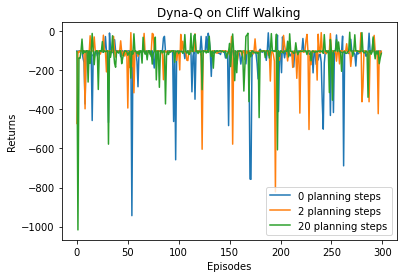

In [15]:
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]
for n_planning in n_planning_list:
    print('Q-planning步数为：%d' % n_planning)
    time.sleep(0.5)
    return_list = DynaQ_CliffWalking(n_planning)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()